<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.883 · Aprendizaje por refuerzo</p>
<p style="margin: 0; text-align:right;">Máster universitario en Ciencia de datos (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC2: Deep Reinforcement Learning
 

En esta práctica se implementarán tres modelos de DRL en un mismo entorno, con el objetivo de analizar distintas formas de aprendizaje de un agente y estudiar su rendimiento. El agente será entrenado con los métodos:

<ol>
    <li>DQN</li>
    <li>Double DQN (DDQN)</li>
    <li>REINFORCE con línea de base</li>
    <li>REINFORCE con reward modificado </li>
 </ol>
 
Finalmente, crearemos un entorno de cero y lo resolveremos.
 
 
**Importante: La entrega debe hacerse en formato notebook y en formato html donde se vea el código y los resultados y comentarios de cada ejercicio. Para exportar el notebook a html puede hacerse desde el menú File  →  Download as  →  HTML.**

# Autor: Mario Ubierna San Mamés

## 0. Contexto

**Mountain Car** consiste en un coche situado en un valle. El coche tiene muy poca potencia y sólo con su motor no es capaz de salir del valle porque la gravedad es más fuerte. Para ello, el agente debe conseguir impulsar el coche, ya sea acelerando hacia adelante o hacia atrás a la velocidad más adecuada para poder  llegar a la cima de la montaña y salir del valle.

Las acciones que puede realizar el coche son las siguientes:
<ul>
    <li>0 : Acelerar hacia a la izquierda</li>
    <li>1 : No usar el motor</li>
    <li>2 : Acelerar hacia la derecha</li>
</ul>

![title](mountainCar.jpg)

El agente recibirá una recompensa (penalización) de -1 cada vez que no consiga llegar a la posición objetivo.

Para más detalles sobre la definición del entorno de MountainCar, se recomienda consultar el código fuente: https://github.com/openai/gym/blob/master/gym/envs/classic_control/mountain_car.py

Cada episodio termina cuando el coche ha llegado al punto objetivo o si se han realizado 200 pasos. La solución óptima es aquella en la que el agente, con un desplazamiento eficiente, consigue llegar a la cima en el menor número de pasos posible.

<!-- Sure, in the second solution, I modified the reward function so that the agent received a reward based on its position. If the agent failed an episode by not getting to the top of the hill but got further to the right from the previous episode it still learns that going right is better even though it ultimately failed the task. Without this reinforcement, the agent has to reach the top of the hill by random chance before receiving a reward signal that causes it to modify its behavior in future episodes. -->

## 1. Inicialización y exploración del entorno (0.5 ptos)

Empezaremos cargando las principales librerías necesarias para la práctica:

In [1]:
import gym
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import numpy as np
import time

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (0.1 ptos):</strong> Inicializar el entorno 'MountainCar-v0'. Extraer:
    
   <ul>
        <li>Valor del umbral de recompensa definido en el entorno</li>
        <li>Máximo de pasos establecidos por cada episodio</li>
        <li>Dimensión del espacio de acciones</li>
        <li>Espacio de estados</li>
        <li>Dimensión del espacio de estados</li>
        <li>Valores mínimos permitidos de posición y velocidad</li>
       <li>Valores máximos permitidos de posición y velocidad</li>
</ul>
</div>

In [2]:
env = gym.make('MountainCar-v0')

In [3]:
print("El valor del umbral de recompensa es: {}".format(env.spec.reward_threshold))
print("El máximo número de pasos por episodio es: {}".format(env.spec.max_episode_steps))
print("La dimensión del espacio de acciones es: {}".format(env.action_space.n))
print("El espacio de estados es: {}".format(env.observation_space))
print("La dimensión del espacio de estados: {}".format(env.observation_space.shape[0]))
print("El valor mínimo de posición: {}".format(env.env.min_position))
print("El valor mínimo de velocidad: {}".format(-env.env.max_speed))
print("El valor máximo de posición: {}".format(env.env.max_position))
print("El valor máximo de velocidad: {}".format(env.env.max_speed))

El valor del umbral de recompensa es: -110.0
El máximo número de pasos por episodio es: 200
La dimensión del espacio de acciones es: 3
El espacio de estados es: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
La dimensión del espacio de estados: 2
El valor mínimo de posición: -1.2
El valor mínimo de velocidad: -0.07
El valor máximo de posición: 0.6
El valor máximo de velocidad: 0.07


<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (0.2 ptos):</strong> Mostrar la representación vectorial de cada observación del entorno junto con la acción aleatoria seleccionada (ej. 'Observation: [..] , Action: Accelerate left'), en un intervalo de 10 episodios de 100 pasos cada uno.
    
<i>Opcional</i>: visualizar los 10 episodios <code>env.render()</code>, sólo posible en local
</div>

In [4]:
def translate_action(action):
    actions_space = {
        0: "Accelerate left",
        1: "No accelerating",
        2: "Accelerate right"
    }
    return actions_space[action]

In [27]:
num_episodios = 10
num_pasos = 100

for episodio in range(num_episodios):
    obs = env.reset()
    print("***********")
    print("Episode: " + str(episodio + 1))
    print("***********")
    
    for paso in range(num_pasos):
        linea = ""
        # Añadimos la observación
        linea += str(obs)
        # Añadimos la acción
        accion = env.action_space.sample()
        linea += " -> " + translate_action(accion)
        
        new_obs, reward, done, info = env.step(accion)
        obs = new_obs
        print(linea)
        if done:
            print(str(obs) + " -> End")
            break

***********
Episode: 1
***********
[-0.50506914  0.        ] -> Accelerate left
[-0.506208  -0.0011389] -> Accelerate left
[-0.5084773  -0.00226927] -> Accelerate right
[-0.5098599  -0.00138264] -> Accelerate left
[-0.5123456  -0.00248566] -> Accelerate left
[-0.51591563 -0.00357004] -> No accelerating
[-0.5195433  -0.00362766] -> Accelerate left
[-0.52420133 -0.00465807] -> No accelerating
[-0.5288549  -0.00465355] -> No accelerating
[-0.5334691  -0.00461413] -> No accelerating
[-0.53800917 -0.00454012] -> No accelerating
[-0.54244125 -0.00443207] -> Accelerate right
[-0.5457321  -0.00329083] -> No accelerating
[-0.54885703 -0.00312495] -> No accelerating
[-0.55179274 -0.0029357 ] -> Accelerate right
[-0.5535172  -0.00172449] -> Accelerate right
[-5.5401760e-01 -5.0040765e-04] -> Accelerate left
[-0.5552902  -0.00127258] -> Accelerate right
[-5.5532545e-01 -3.5254954e-05] -> No accelerating
[-5.5512315e-01  2.0233612e-04] -> Accelerate left
[-0.5556847  -0.00056158] -> No accelerating

[-0.5542175   0.00697409] -> No accelerating
[-0.5470141   0.00720341] -> No accelerating
[-0.53963524  0.00737888] -> No accelerating
[-0.53213614  0.0074991 ] -> Accelerate right
[-0.52357304  0.00856313] -> Accelerate left
[-0.5160101   0.00756293] -> Accelerate left
[-0.5095041   0.00650602] -> Accelerate right
[-0.5021037   0.00740035] -> Accelerate right
[-0.49386448  0.00823924] -> Accelerate left
[-0.48684794  0.00701653] -> Accelerate right
[-0.4791065   0.00774146] -> No accelerating
[-0.47169772  0.00740876] -> No accelerating
[-0.46467665  0.00702107] -> Accelerate right
[-0.4570952   0.00758145] -> Accelerate left
[-0.4510092   0.00608598] -> Accelerate right
[-0.44446337  0.00654585] -> Accelerate left
[-0.4395055   0.00495789] -> Accelerate left
[-0.43617162  0.00333386] -> Accelerate left
[-0.43448597  0.00168565] -> Accelerate left
[-4.3446073e-01  2.5236639e-05] -> Accelerate left
[-0.4360961  -0.00163536] -> Accelerate left
[-0.43938023 -0.00328412] -> Accelerate rig

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (0.2 ptos):</strong> Ejecutar 1000 episodios con el máximo de pasos establecido en el entorno de MountainCar, tomando acciones de forma aleatoria. Almacenar la posición final del coche en cada episodio, y mostrar el resultado en un gráfico. Comentar el resultado.
</div>

Text(0, 0.5, 'Posición')

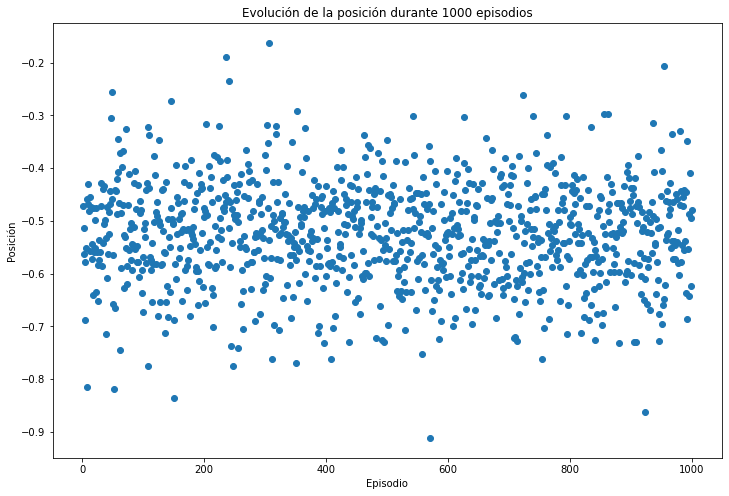

In [26]:
num_episodios = 1000
num_pasos = 200
pos_episodio = []

for episodio in range(num_episodios):
    obs = env.reset()
    pos_paso = []
    
    for paso in range(num_pasos):
        pos_paso.append(obs[0])
        accion = env.action_space.sample()
        new_obs, reward, done, info = env.step(accion)
        obs = new_obs
        if done:
            pos_paso.append(obs[0])
            break
    
    pos_episodio.append(pos_paso[-1])

fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(range(1, num_episodios + 1), pos_episodio)
plt.title("Evolución de la posición durante {} episodios".format(num_episodios))
plt.xlabel("Episodio")
plt.ylabel("Posición")

De la anterior ejecución podemos observar que nunca llegamos a la meta (cuando la posición es mayor que 0.5). Además, observamos que el proceso de aprendizaje es totalmente aleatorio, no hay mejora, esto es normal ya que las acciones se han tomado de forma aleatoria.

Un punto interesante sería ver cuánto tarda en converger el algoritmo para llegar del estado inicial al estado final, para ello solo hay que comentar la línea de código `obs = env.rest()`, de esta forma para cada episodio vamos a partir de la posición final alcanzada en el episodio anterior.

## 2. Agente DQN (2.5 ptos)

En este apartado implementaremos una DQN teniendo en cuenta la exploración-explotación (epsilon-*greedy*), la red objetivo, y el buffer de repetición de experiencias.

Definiremos el buffer como sigue:

In [18]:
from collections import namedtuple, deque

In [19]:
class experienceReplayBuffer:

    def __init__(self, memory_size=50000, burn_in=10000):
        self.memory_size = memory_size
        self.burn_in = burn_in
        self.buffer = namedtuple('Buffer', 
            field_names=['state', 'action', 'reward', 'done', 'next_state'])
        self.replay_memory = deque(maxlen=memory_size)

    def sample_batch(self, batch_size=32):
        samples = np.random.choice(len(self.replay_memory), batch_size, 
                                   replace=False)
        # Use asterisk operator to unpack deque 
        batch = zip(*[self.replay_memory[i] for i in samples])
        return batch

    def append(self, state, action, reward, done, next_state):
        self.replay_memory.append(
            self.buffer(state, action, reward, done, next_state))

    def burn_in_capacity(self):
        return len(self.replay_memory) / self.burn_in

Primeramente implementaremos la red neuronal, utilizando un modelo Secuencial con la siguiente configuración:
<ul>
    <li>Tres capas completamente conectadas (representadas en pytorch por <code>nn.Lineal</code>) con 512, 216 y 128 neuronas cada una, <code>bias=True</code>, y activación ReLU </li>
    <li>Una capa de salida completamente conectada y <code>bias=True</code> </li>
</ul>

Usaremos el optimizador Adam para entrenar la red.

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Ejercicio (0.75 ptos):</strong> Implementar la clase <code>NeuralNet()</code>. Inicializar las variables necesarias y definir el modelo Secuencial de red neuronal indicado.

-----------------------------------------------------------------------------------------------------------
<b>Nota</b>: se os proporciona el código pre-implementado. La implementación que se pide en el enunciado está indicada en los bloques <i>TODO</i> y/o con variables igualadas a <i>None</i>.
</div>

In [20]:
class NeuralNet(torch.nn.Module):  

    def __init__(self, env, learning_rate=1e-3):
        
        """
        Params
        ======
        n_inputs: tamaño del espacio de estadps
        n_outputs: tamaño del espacio de acciones
        actions: array de acciones posibles
        """
        ######################################
        ##TODO: Inicializar parámetros
        super(NeuralNet, self).__init__()
        self.n_inputs = None
        self.n_outputs = None
        self.actions = None
        self.learning_rate = None
        
        
       
        #######################################
        ##TODO: Neural network
        self.model = None
        
        
        
        
        #######################################
        ##TODO: Initialize optimizer
        self.optimizer = None


          


    ### e-greedy method
    def get_action(self, state, epsilon=0.05):
        if np.random.random() < epsilon:
            action = np.random.choice(self.actions)  # acción random
        else:
            qvals = self.get_qvals(state)  # acción del cálculo de Q para esta acción
            action= torch.max(qvals, dim=-1)[1].item()
        return action
    
    
    def get_qvals(self, state):
        if type(state) is tuple:
            state = np.array([np.ravel(s) for s in state])
        state_t = torch.FloatTensor(state)
        return self.model(state_t)  

A continuación implementaremos una clase que defina el comportamiento del agente DQN teniendo en cuenta:
    <ul>
        <li>La exploración/explotación (decaimiento de epsilon)</li>
        <li>La actualización y sincronización de la red principal y la red objetivo (pérdida)</li>
    </ul>
    
    
Consideraremos que el agente ha aprendido a realizar la tarea (i.e. el "juego" termina) cuando obtiene una media de mínimo -110 puntos durante 100 episodios consecutivos.


<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (75 ptos):</strong> Implementar los siguientes puntos de la clase <code>DQNAgent()</code>:
    <ol>
        <li>Declarar las variables de la clase</li>
        <li>Inicializar las variables necesarias</li>
        <li>Implementar la acción a tomar</li>
        <li>Actualizar la red principal según la frecuencia establecida en los hiperparámetros</li>
        <li>Calcular la pérdida (ecuación Bellman, etc)</li> 
        <li>Sincronizar la red objetivo según la frecuencia establecida en los hiperparámetros</li>
        <li>Calcular la media de recompensas de los últimos 100 episodios</li>
        <li>Comprobar límite de episodios</li>
        <li>Actualizar epsilon según: $$\textrm{max}(\epsilon · \epsilon_{\textrm{decay}}, 0.01)$$ </li>
    </ol>
Además, durante el proceso se deben almacenar (*):
    <ul>
        <li>Las recompensas obtenidas en cada paso del entrenamiento</li>
        <li>Las recompensas medias cada 100 episodios</li>
        <li>La pérdida durante el entrenamiento</li>
        <li>La posición final del coche en cada episodio</li>
        <li>La evolución de epsilon a lo largo del entrenamiento</li>
    </ul>

-----------------------------------------------------------------------------------------------------------
<b>Nota</b>: se os proporciona el código pre-implementado. La implementación que se pide en el enunciado está indicada en los bloques <i>TODO</i> y/o con variables igualadas a <i>None</i>, salvo (*) en qué momento almacenar las variables que se indican.
</div>

In [21]:
from copy import deepcopy, copy

In [22]:
class DQNAgent:
    
    ######################################
    ##TODO 1: Declarar variables
    def __init__(self, env, main_network, buffer, reward_threshold, epsilon=0.1, eps_decay=0.99, batch_size=32):
        
        self.env = None
        self.main_network = None
        self.target_network = None 
        self.buffer = None
        self.epsilon = None
        self.eps_decay = None
        self.batch_size = None
        self.reward_threshold = None
        self.nblock = None # bloque de los X últimos episodios de los que se calculará la media de recompensas
        self.initialize()           
   
    ######################################
    ##TODO 2: Inicializar otras variables necesarias

    
    
    
    
    
    ######################################
    ##TODO 3: Tomar paso siguiente
    def take_step(self, eps, mode='train'):
        if mode == 'explore': 
            action = None  # acción aleatoria en el burn-in
        else:
            action = None # acción a partir del valor de Q (elección de la acción con mejor Q)
            self.step_count += 1
            
        #TODO: tomar 'step' i obtener nuevo estado y recompensa. Guardar la experiencia en el buffer

        
        
        
        #TODO: resetear entorno 'if done'


        
    
        
    ## TRAINING
    def train(self, gamma=0.99, max_episodes=50000, 
              batch_size=32,
              dnn_update_frequency=4,
              dnn_sync_frequency=2000):
        
        self.gamma = gamma

        # Rellenamos el buffer con N experiencias aleatorias ()
        print("Filling replay buffer...")
        while self.buffer.burn_in_capacity() < 1:
            self.take_step(self.epsilon, mode='explore')

            
        episode = 0
        training = True
        print("Training...")
        while training:
            self.state0 = self.env.reset()
            self.total_reward = 0
            gamedone = False
            while gamedone == False:
                # El agente toma una acción
                gamedone = self.take_step(self.epsilon, mode='train')
                
                #################################################################################
                #####TODO 4:  Actualizar la red principal según la frecuencia establecida #######
                
                
                
                
                
                
                ########################################################################################
                ###TODO 6: Sincronizar red principal y red objetivo según la frecuencia establecida#####
                
                
                
   
                
                
                if gamedone:                   
                    episode += 1

                    self.update_loss = []   
                
                    
                    #######################################################################################
                    ###TODO 7: calcular la media de recompensa de los últimos X episodios, y almacenar#####

                    
                    
                    
                    


                    print("\rEpisode {:d} Mean Rewards {:.2f} Epsilon {}\t\t".format(
                        episode, mean_rewards, self.epsilon), end="")
                    
                    #######################################################################################
                    ### TODO 8: Comprobar que todavía quedan episodios. Parar el aprendizaje si se llega al límite

                    
                    
                    

                    
                    #Termina el juego si la media de recompensas ha llegado al umbral fijado para este juego  
                    if mean_rewards >= self.reward_threshold:
                        training = False
                        print('\nEnvironment solved in {} episodes!'.format(
                            episode))
                        break
                    
                    
                    #################################################################################
                    ######TODO 9: Actualizar epsilon según la velocidad de decaimiento fijada########

              
            
            
            
                
    #####################################         
    #####TODO 5: cálculo de la pérdida###
    def calculate_loss(self, batch):
        # Separamos las variables de la experiencia y las convertimos a tensores 
        states, actions, rewards, dones, next_states = [i for i in batch] 
        rewards_vals = torch.FloatTensor(rewards)
        actions_vals = torch.LongTensor(np.array(actions)).reshape(-1,1)
        dones_t = torch.ByteTensor(dones)
        
        # Obtenemos los valores de Q de la red principal
        qvals = torch.gather(self.main_network.get_qvals(states), 1, actions_vals)
        # Obtenemos los valores de Q objetivo. El parámetro detach() evita que estos valores actualicen la red objetivo
        qvals_next = torch.max(self.target_network.get_qvals(next_states),
                               dim=-1)[0].detach()
        qvals_next[dones_t] = 0 # 0 en estados terminales
        
        #################################################################################
        ### TODO: Calcular ecuación de Bellman
        expected_qvals = None
        
        #################################################################################
        ### TODO: Calcular la pérdida (MSE)
        loss = None
        
        return loss

    
    def update(self):
        self.main_network.optimizer.zero_grad()  # eliminamos cualquier gradiente pasado
        batch = self.buffer.sample_batch(batch_size=self.batch_size) # seleccionamos un conjunto del buffer
        loss = self.calculate_loss(batch) # calculamos la pérdida
        loss.backward() # hacemos la diferencia para obtener los gradientes
        self.main_network.optimizer.step() # aplicamos los gradientes a la red neuronal
        # Guardamos los valores de pérdida
        self.update_loss.append(loss.detach().numpy())

A continuación entrenaremos el modelo con los siguientes hiperparámetros:
   <ul>
        <li>Velocidad de aprendizaje: 0.001</li>
        <li>Tamaño del batch: 32</li>
        <li>Número de episodios: 5000</li>
        <li>Número de episodios para rellenar el buffer: 1000</li>
        <li>Frecuencia de actualización de la red neuronal: 3 </li>
        <li>Frecuencia de sincronización con la red objetivo: 1000</li>
        <li>Capacidad máxima del buffer: 10000</li>
        <li>Factor de descuento: 0.99</li>
        <li>Epsilon: 1, con decaimiento de 0.99</li>
    </ul>

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (0.25 ptos):</strong> Declarar los hiperparámetros, cargar el modelo de red neuronal y entrenar el agente. Guardar el modelo entrenado en formato ".pth".
</div>

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (0.25 ptos):</strong> Representar:
    <ol>
        <li>Gráfico con las recompensas obtenidas a lo largo del entrenamieno, la evolución de las recompensas medias cada 100 episodios, y el umbral de recompensa establecido por el entorno.</li>
        <li>Gráfico con la posición final del coche en cada episodio</li>
        <li>Gráfico con la evolución de la perdida a lo largo del entrenamiento</li>
        <li>Gráfico con la evolución de epsilon a lo largo del entrenamiento</li>
    </ol>

Comentar los resultados obtenidos.
</div>

Una vez entrenado el agente, nos interesa comprobar cómo de bien ha aprendido y si es capaz de conseguir que el coche llegue a su objetivo. Para ello, recuperamos el modelo entrenado y dejamos que el agente tome acciones aleatorias según ese modelo y observamos su comportamiento.

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (0.5 ptos):</strong> Cargar el modelo entrenado y ejecutar el agente entrenado durante 100 episodios consecutivos. Almacenar la posición final del agente en cada episodio, y calcular la suma de recompensas por cada episodio. Mostrar:
    <ul>
        <li>un gráfico con la suma de las recompensas respecto de los episodios, incluyendo el umbral de recompensa establecido por el entorno</li>
        <li> un gráfico con la posición final del coche en cada episodio</li>
    </ul>

Comentar los resultados obtenidos.

---------------------------------------------------------------------------------------------------
<i>Opcional</i>: visualizar los episodios con <code>env.render()</code>, sólo posible en local. Esta visualización ralentiza el proceso unos segundos por episodio.
</div>

## 3. Agente DDQN (2.5 ptos)

En este apartado implementaremos una doble DQN con la misma red neuronal y características de la DQN del apartado anterior. 

Recordemos que con la doble DQN, es la red principal la que elije la acción con mayor valor de Q, y la red objetivo la que proporciona el valor objetivo de Q para esa
acción, es decir, la que dirá qué recompensa tiene esa acción elegida por la red principal. 

Siguiendo el mismo esquema que en el ejercicio anterior, a continuación implementaremos una clase que defina el entrenamiento del agente teniendo en cuenta: 
    <ul>
        <li>La exploración/explotación (decaimiento de epsilon)</li>
        <li>La actualización y sincronización de la red principal y la red objetivo (pérdida)</li>
    </ul>
    
Consideraremos que el agente ha aprendido a realizar la tarea (i.e. el "juego" termina) cuando obtiene una media de mínimo -110 puntos durante 100 episodios consecutivos.


<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (1 pto):</strong> Implementar los siguientes puntos de la clase <code>DDQNAgent()</code> siguiendo el mismo esquema de implementación realizado con el método <code>DQNAgent()</code>
</div>

In [45]:
class DDQNAgent:

    #TODO

A continuación entrenaremos el modelo con los mismos hiperparámetros que con la DQN.

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (0.25 ptos):</strong> Entrenar el agente. Guardar el modelo entrenado en formato ".pth".
</div>

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (0.25 ptos):</strong> Representar:
    <ol>
        <li>Gráfico con las recompensas obtenidas a lo largo del entrenamieno, la evolución de las recompensas medias cada 100 episodios, y el umbral de recompensa establecido por el entorno</li>
        <li>Gráfico con la posición final del coche en cada episodio</li>
        <li>Gráfico con la evolución de la perdida a lo largo del entrenamiento</li>
        <li>Gráfico con la evolución de epsilon a lo largo del entrenamiento</li>
  </ol>
Comentar los resultados obtenidos.
</div>

Una vez entrenado el agente, nos interesa comprobar cómo de bien ha aprendido, si el "robot" es capaz de realizar las tareas aprendidas. Para ello, recuperamos el modelo entrenado y dejamos que el agente tome acciones aleatorias según ese modelo y observamos su comportamiento.

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (0.5 ptos):</strong> Cargar el modelo entrenado y ejecutar el agente entrenado durante 100 episodios consecutivos. Almacenar la posición final del agente en cada episodio, y calcular la suma de recompensas por cada episodio. Mostrar:
    <ul>
        <li>un gráfico con la suma de las recompensas respecto de los episodios, incluyendo el umbral de recompensa establecido por el entorno</li>
        <li> un gráfico con la posición final del coche en cada episodio</li>
    </ul>

Comentar los resultados obtenidos.
    
---------------------------------------------------------------------------------------------------
<i>Opcional</i>: visualizar los episodios con <code>env.render()</code>, sólo posible en local. Esta visualización ralentiza el proceso unos segundos por episodio.
</div>

## 4. REINFORCE con línea de base (2 ptos)

En este apartado implementaremos un modelo basado en Gradientes de Política, el método de REINFORCE con línea de base.

Utilizaremos un modelo Secuencial con la siguiente configuración:
<ul>
    <li>Tres capas completamente conectadas de 64, 32 y 16 neuronas respectivamente, <code>bias=True</code>, y activación tangencial</li>
    <li>Una capa de salida completamente conectada, <code>bias=True</code>, y activación Softmax (dim=-1)
</ul>

Usaremos el optimizador Adam para entrenar la red.

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (0.75 ptos):</strong> Implementar la clase <code>PGReinforce()</code>. Inicializar las variables necesarias y definir el modelo Secuencial de red neuronal indicado.

-----------------------------------------------------------------------------------------------------------
<b>Nota</b>: se os proporciona el código pre-implementado. La implementación que se pide en el enunciado está indicada en los bloques <i>TODO</i> y/o con variables igualadas a <i>None</i>.
</div>

In [3]:
class NeuralNetReinforce(torch.nn.Module):

    def __init__(self, env, learning_rate=1e-3):
        """
        Params
        ======
        n_inputs: tamaño del espacio de estadps
        n_outputs: tamaño del espacio de acciones
        learning_rate: velocidad aprendizaje
        """       
        super(NeuralNetReinforce, self).__init__()
        
        ###################################
        ####TODO: Inicializar parámetros#### 

        
        
        

        
        #######################################
        ##TODO: Construcción de la red neuronal 
        self.model = None
        
        
        
        
        
        
        #######################################
        ##TODO: Inicializar el optimizador
        self.optimizer = None
        


    #Obtención de las probabilidades de las posibles acciones       
    def get_action_prob(self, state):
        action_probs = self.model(torch.FloatTensor(state))
        return action_probs

A continuación definiremos el comportamiento del agente. En este caso no tendremos en cuenta el umbral de recompensa en la finalización del aprendizaje, sino **dejaremos al agente realizar el máximo de episodios establecido**.

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (0.75 ptos):</strong> Implementar la clase <code>reinforceAgent()</code> teniendo en cuenta los siguientes puntos:
    <ol>
        <li>Inicializar parámetros</li>
        <li>Inicializar las variables necesarias</li>
        <li>Implementar la acción a tomar</li>
        <li>Calcular el <i>discounted rewards</i> usando como línea de base la media del retorno estandarizada</li>
        <li>Calcular la media de recompensas de los últimos 100 episodios</li>
        <li>Actualizar red, almacenar pérdida y resetear variables cuando se completa el batch</li>
        <li>Implementar la pérdida por actualización</li>
        <li>Hacer las comprobaciones necesarias de fin de episodio</li>
    </ol>
Además, durante el proceso se deben almacenar (*):
    <ul>
        <li>Las recompensas obtenidas en cada paso del entrenamiento</li>
        <li>Las recompensas medias cada 100 episodios</li>
        <li>La posición final del coche en cada episodio</li>
        <li>La pérdida durante el entrenamiento</li>
    </ul>


-----------------------------------------------------------------------------------------------------------
<b>Nota</b>: se os proporciona el código pre-implementado. La implementación que se pide en el enunciado está indicada en los bloques <i>TODO</i> y/o con variables igualadas a <i>None</i>, salvo (*) en qué momento almacenar las variables que se indican.
</div>

In [58]:
class reinforceAgent:
    
    def __init__(self, env, main_network):
        """
        Params
        ======
        env: entorno
        main_network: clase con la red neuronal diseñada
        nblock: bloque de los X últimos episodios de los que se calculará la media de recompensa
        """    
        
        ###################################################
        ######TODO 1: inicializar parámetros ##################

        
        
        
        
        self.initialize()

        
    ###############################################################
    #####TODO 2: inicializar variables extra que se necesiten######:
    def initialize(self):
        self.batch_rewards = []
        self.batch_actions = []
        self.batch_states = []
        self.batch_counter = 1
    
    
    
    
    

        
    ## TRAINING
    def train(self, gamma=0.99, max_episodes=2000, batch_size=10):
        self.gamma = gamma
        self.batch_size = batch_size
        
        episode = 0
        action_space = np.arange(self.env.action_space.n)
        training = True
        print("Training...")
        while training:
            state0 = env.reset()
            episode_states = [] #array para almacenar estados
            episode_rewards = [] #array para almacenar rewards
            episode_actions = [] #array para almacenar acciones
            gamedone = False
            
            while gamedone == False:
                ###########################################################
                ######TODO 3:  Tomar nueva acción ##############################################
                action_probs = None  #distribución de probabilidad de las acciones dado el estado actual
                action = None   #acción aleatoria de la distribución de probabilidad
                next_state, reward, gamedone, _ = None
                
                                
                #TODO: Almacenamos experiencias (estados, rewards y acciones) que se van obteniendo en este episodio

                
                
                
                
                state0 = None
                
                
                if gamedone:
                    episode += 1
                    
                    # Calculamos el término del retorno menos la línea de base
                    self.batch_rewards.extend(self.discount_rewards(episode_rewards))
                    self.batch_states.extend(episode_states)
                    self.batch_actions.extend(episode_actions)
                    
                    
                    #####################################################################################
                    ###TODO 5: calcular media de recompensas de los últimos X episodios#####

                    
                    
                    
                    

                    
                    #####################################################################################
                    ###TODO 6: Cuando se completa el tamaño del batch: actualizar la red (update), almacenar 
                    #la pérdida del entrenamiento, y resetear las variables del episodio necesarias

 






                  
                    self.batch_counter += 1
                    print("\rEpisode {:d} Mean Rewards {:.2f}\t\t".format(
                        episode, mean_rewards), end="")
         
        
                    #####################################################################################
                    ###TODO 8:Hacer las comprobaciones necesarias de fin de episodio
                    
                    
                    
                    
                    
                          

    ########################################################
    ###TODO 4: cálculo del retorno menos la línea de base###                  
    def discount_rewards(self, rewards):

        
        
        
        
        

        
 

    #################################################
    ###TODO 7: Cálculo de la pérdida#################
    # Recordatorio: cada actualización es proporcional al producto del retorno y el gradiente de la probabilidad
    # de tomar la acción tomada, dividido por la probabilidad de tomar esa acción (logaritmo natural)
    def calculate_loss(self, state_t, action_t, reward_t):
        logprob = torch.log(self.main_network.get_action_prob(state_t))
        selected_logprobs = None
        loss = None
        return loss


        
    ## Actualización                
    def update(self, batch_s, batch_r, batch_a):
        self.main_network.optimizer.zero_grad()  # eliminamos cualquier gradiente pasado
        state_t = torch.FloatTensor(batch_s)
        reward_t = torch.FloatTensor(batch_r)       
        action_t = torch.LongTensor(batch_a)             
        loss = self.calculate_loss(state_t, action_t, reward_t) # calculamos la pérdida
        loss.backward() # hacemos la diferencia para obtener los gradientes
        self.main_network.optimizer.step() # aplicamos los gradientes a la red neuronal
        # Guardamos los valores de pérdida
        self.update_loss.append(loss.detach().numpy())
        


### Entrenamiento

A continuación entrenaremos el modelo con los siguientes hiperparámetros:
   <ul>
        <li>Velocidad de aprendizaje: 0.01</li>
        <li>Tamaño del batch: 8</li>
        <li>Gamma: 0.99</li>
        <li>Número máximo de episodios: 5000</li>
</ul>

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (0.25 ptos):</strong> Definir los hiperparámetros, cargar el modelo de red neuronal y entrenar el agente
</div>

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis (0.25 ptos):</strong> ¿Qué ha ocurrido? ¿El agente es capaz de aprender la tarea? ¿Por qué? 
</div>

### 4.1 Modificación de la recompensa

Como hemos visto, el entorno de MountainCar únicamente proporciona recompensa cuando el agente llega al objetivo. Pero no hay otras indicaciones que permitan al agente saber que está yendo en la buena dirección de aprendizaje, lo que hace el aprendizaje un poco aleatorio y difícil para el agente. 

En este apartado vamos a modificar la recompensa del agente REINFORCE creando una función que dé al agente una recompensa según la posición en la que se encuentra. Que aunque no llegue al objetivo final pueda al menos saber que no iba tan mal encaminado. 

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (0.25 ptos):</strong> Definir una función <code>get_reward()</code> en la que, si el agente se encuentra:
<ul>
<li>en una posición mayor o igual a 0.5, la recompensa será: +10</li>
<li>en una posición mayor que -0.4, la recompensa será: $(1+s)^2$ , es decir, proporcional a la posición</li>
<li>en cualquier otra posición, se le penalizará con una recompensa de: -1 </li>
</ul>
</div>

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (0.5 ptos):</strong> Modificar la clase <code>reinforceAgent</code> del ejercicio anterior para que el agente reciba las nuevas recompensas. Entrenar el agente con los mismos parámetros que en el ejercicio anterior, y mostrar las gráficas de recompensas y de la posición final del coche en cada episodio.
</div>

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Análisis (0.2 ptos):</strong> Comentar los resultados obtenidos. ¿Ha conseguido el agente REINFORCE aprender a llegar al objetivo? Indicar qué se podría hacer para mejorar el resultado.
</div>

## 5. Comparación de modelos (0.5 ptos)

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio:</strong> Mostrar en un mismo gráfico la evolución de la media de recompensas de los modelos DQN y DDQN, junto con el umbral de recompensa. Comentar los resultados.
</div>

## 6. Creación de un entorno en Gym (2 ptos)

En este ejercicio diseñaremos un entorno sencillo siguiendo el esquema de los entornos de <code>gym</code>, y trataremos de resolverlo.

Los entornos de <code>gym</code> suelen tener la siguiente estructura:

```
class FooEnv(gym.Env):
  metadata = {'render.modes': ['human']}

  def __init__(self):
    ...
  def step(self, action):
    ...
  def reset(self):
    ...
  def render(self, mode='human', close=False):
    ...
 
 ```
 
Para nuestro entorno usaremos todas estas funciones salvo el <code>render</code> (relativo al diseño de la visualización el entorno).

Primeramente importamos la librerías necesarias:

In [58]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random

### 6.1 Entorno

El entorno que vamos a diseñar consiste en un regulador de temperatura. Imaginemos que queremos tener una ducha inteligente que sea capaz de mantener la temperatura en un intervalo concreto (37-39 grados) durante todo el tiempo de baño que fijemos. Cada acción será subir o bajar la temperatura un grado, o mantener la temperatura actual.

Concretamente queremos que el regulador de temperatura tenga las siguientes características:
    <ul>
        <li>La temperatura (i.e. estado) puede oscilar entre los 0 y los 100 grados</li>
        <li>La temperatura inicial (i.e. estado inicial) será de 38+-3 grados</li>
        <li>La duración del baño debe ser de 3 minutos (180 segundos)</li>
        <li>Las acciones posibles seran:
            <ul>
                <li>0 : bajar temperatura un grado</li>
                <li>1 : mantener temperatura</li>
                <li>2 : subir temperatura un grado</li>
            </ul></li>
        <li>La recompensa será de +1 si la temperatura se encuentra entre 37 y 39 grados, de lo contrario será -1</li>
        <li>El episodio termina cuando el tiempo de baño se agota (se cumplen los 180 segundos)</li>
    </ul>


<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Ejercicio (0.75 ptos):</strong> Diseñar el entorno <code>TempControlEnv</code> con las características indicadas.
</div>

In [59]:
class TempControlEnv(Env):
    def __init__(self):
        '''
        Argumentos:
            - espacio de acciones
            - espacio de observaciones (se recomienda usar la función Box)
            - estado inicial
            - duración episodio
        '''
        ###TODO: inicializar variables###
    
    
        
        
        
        
    def step(self, action):
        '''
        Argumentos:
            - temperatura según acción tomada
            - disminución tiempo de baño
        '''
     
        ###TODO: nueva temperatura y còmput de reducción del tiempo de baño###

      
    

        
        ###TODO: Cálculo de las recompensas###
        
        
        

        
        ###TODO: Comprobar si el tiempo de baño se ha agotado###
        
        

        
        
        # Aplicamos ruido a la temperatura (exe: alguien abre el agua caliente de otro grifo
        # y altera la temperatura del agua de nuestra ducha)
        self.state += random.randint(-1,1)  # Apply some temperature noise 
        
        info = {} # Set placeholder for info
        
        # Return step information
        return self.state, reward, done, info

    
    
    def reset(self):  
        '''
        Argumentos:
            - resetear temperatura inicial
            - resetear tiempo de baño
        '''
        
        ###TODO: resetear variables###

    
    
        return self.state

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Ejercicio (0.25 ptos):</strong> Cargar el entorno <code>TempControlEnv</code> y mostrar el espacio de acciones y el espacio de observaciones. Ejecutar 10 episodios con acciones aleatorias, mostrando el episodio y la recompensa obtenida.
</div>

### 6.2 Agente regulador de la temperatura

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (1 pto):</strong> Implementar un agente capaz de regular la temperatura y mantenerla en los intervalos establecidos por el entorno <code>TempControlEnv</code> diseñado. Se puede implementar cualquier tipo de agente visto en el curso (módulos 9, 10 y 11) con los hiperparámetros que se considere conveniente.
    <ul>
        <li>Mostrar gráficamente la evolución de las recompensas</li>
        <li>Mostrar gráficamente la evolución de la temperatura final de cada episodio a lo largo del entrenamiento</li>
        <li>Testear el modelo de agente con 100 episodios y mostrar las gráficas de recompensas y temperatura</li>
    </ul>
</div>